# Importação das Bibliotecas:


In [ ]:
import pandas as pd
import seaborn as sn
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import plotly.express as px
plt.rc('figure', figsize = (10, 10))
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split
# Métricas
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
# Funções matemáticas
import math

In [ ]:
import matplotlib.style as style
style.available
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')


<ipython-input-3-740ef7d9567b>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-poster') #sets the size of the charts


--------------------------------------------------------------------------------

# Importação do Dataset:

In [ ]:
path = "https://raw.githubusercontent.com/joaocmfnogueira/basesCompeticaoIA/main/Competicao_IA_Dados.xlsx%20-%20P%C3%A1gina1.csv"
df = pd.read_csv(path)

In [ ]:
df.head()

,ID,Cidade,Bairro,Tipo,m2,Quartos,Banheiros,Vagas,Preço,Condomínio,IPTU,Latitude,Longitude
0,0,Juiz de Fora - MG,Centro,Studio,34,1,1,0,"R$ 1.400,00","R$ 150,00","R$ 0,00",-21.759859,-43.346727
1,1,Juiz de Fora - MG,Granbery,Apartamento,92,3,2,0,"R$ 1.900,00","R$ 220,00","R$ 161,28",-21.767548,-43.343795
2,2,Juiz de Fora - MG,Santo Antônio,Apartamento,45,2,1,0,"R$ 600,00","R$ 132,00","R$ 125,00",-21.773246,-43.312741
3,3,Juiz de Fora - MG,Centro,Apartamento,71,1,1,1,"R$ 1.400,00","R$ 404,00","R$ 133,00",-21.759859,-43.346727
4,4,Juiz de Fora - MG,Joquei Clube,Apartamento,55,2,1,1,"R$ 700,00","R$ 300,00","R$ 0,00",-21.725834,-43.397439


------------------------------

# Pré-processamento da Base de Dados:


## Tratamentos Iniciais:

In [ ]:
# Corrigindo os nomes para 'Galpão' e 'Salão' corretamente
df['Tipo'] = df['Tipo'].replace({'Ã£': 'ã'}, regex=True)
# Corrigindo o nome para 'Prédio' corretamente
df['Tipo'] = df['Tipo'].replace({'Ã©': 'é'}, regex=True)
# Corrigindo o nome para 'Área' corretamente
df['Tipo'] = df['Tipo'].replace({'Ã_x0081_': 'Á'}, regex=True)
# Retirando as colunas que não são usadas
df = df.drop(['ID', 'Cidade', 'Bairro'], axis= 1)
# Retirando os Tipos de Imóveis não utilizados
df = df.drop(df[df['Tipo'].isin(['Salão', 'Terreno', 'Prédio', 'Sobrado', 'Flat', 'Ponto', 'Área', 'Laje'])].index)
# Retirando os dados desnecessários
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

# Transformando os dados de preços em 'float'
money_col = df[['Preço', 'Condomínio', 'IPTU', 'm2']]
for col in money_col:
    df[col] = df[col].astype(str).apply(lambda x: x.replace('.',''))
    df[col] = df[col].replace({'R\$ ': '', ',': '.', '\$': ''}, regex=True).astype('float64')

# Transformando os dados 'float' em 'int'
int_col = df[['Quartos', 'Banheiros', 'Vagas']]
for col in int_col:
    df[col] = df[col].astype(int)
df = df.reset_index()
df = df.drop(['index'], axis= 1)

In [ ]:
df.head()

,Tipo,m2,Quartos,Banheiros,Vagas,Preço,Condomínio,IPTU,Latitude,Longitude
0,Studio,34.0,1,1,0,1400.0,150.0,0.00,-21.759859,-43.346727
1,Apartamento,92.0,3,2,0,1900.0,220.0,161.28,-21.767548,-43.343795
2,Apartamento,45.0,2,1,0,600.0,132.0,125.00,-21.773246,-43.312741
3,Apartamento,71.0,1,1,1,1400.0,404.0,133.00,-21.759859,-43.346727
4,Apartamento,55.0,2,1,1,700.0,300.0,0.00,-21.725834,-43.397439


## Tratamento de Dados Inconsistentes:


### juntando Tipos de Imóveis:


In [ ]:
df.Tipo.unique()

array(['Studio', 'Apartamento', 'Galpão', 'Casa', 'Sala', 'Cobertura',
       'Loja', 'Kitnet', 'Ã\x81rea'], dtype=object)

In [ ]:
df.loc[df['Tipo'] == "Studio", 'Tipo'] = "Kitnet"
df.loc[df['Tipo'] == "Cobertura", 'Tipo'] = "Apartamento"
df.loc[df['Tipo'] == "Sala", 'Tipo'] = "Galpão"
df = df.drop(df.loc[df['Tipo']=="Ã\x81rea"].index)

np.unique(df['Tipo'], return_counts=True)

(array(['Apartamento', 'Casa', 'Galpão', 'Kitnet', 'Loja'], dtype=object),
 array([518,  72, 103,  50, 173]))

### Tratando Linhas com m2 == 0:

In [ ]:
df2 = df.drop(df[(df["m2"]==0) | (((df["Tipo"] == "Apartamento") | (df["Tipo"] == "Kitnet")) & ((df["Banheiros"] == 0) | (df["Quartos"] == 0)))].index)


In [ ]:
# df2 = df.drop(df[(df["m2"]==0)].index)

In [ ]:
df2.describe()

,m2,Quartos,Banheiros,Vagas,Preço,Condomínio,IPTU,Latitude,Longitude
count,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000
mean,93.386698,1.696093,1.421129,0.738061,1930.937771,226.762127,161.306918,-21.756323,-43.354700
std,181.849424,1.143462,1.062163,1.575900,4385.988276,270.030436,305.180788,0.038082,0.053597
min,1.000000,0.000000,0.000000,0.000000,173.000000,0.000000,0.000000,-21.812230,-44.263968
25%,47.000000,1.000000,1.000000,0.000000,750.000000,100.000000,55.000000,-21.773594,-43.356141
50%,65.000000,2.000000,1.000000,0.000000,1000.000000,190.000000,100.000000,-21.759859,-43.347460
75%,90.000000,2.000000,2.000000,1.000000,1500.000000,282.800000,150.000000,-21.753338,-43.346727
max,4300.000000,10.000000,12.000000,30.000000,85000.000000,3360.000000,3292.000000,-21.134688,-43.011279


In [ ]:
df2

,Tipo,m2,Quartos,Banheiros,Vagas,Preço,Condomínio,IPTU,Latitude,Longitude
0,Kitnet,34.0,1,1,0,1400.0,150.0,0.00,-21.759859,-43.346727
1,Apartamento,92.0,3,2,0,1900.0,220.0,161.28,-21.767548,-43.343795
2,Apartamento,45.0,2,1,0,600.0,132.0,125.00,-21.773246,-43.312741
3,Apartamento,71.0,1,1,1,1400.0,404.0,133.00,-21.759859,-43.346727
4,Apartamento,55.0,2,1,1,700.0,300.0,0.00,-21.725834,-43.397439
...,...,...,...,...,...,...,...,...,...,...
912,Loja,97.0,2,1,1,800.0,200.0,30.00,-21.738407,-43.344741
913,Loja,91.0,2,2,1,1100.0,60.0,0.00,-21.787171,-43.390735
914,Apartamento,51.0,1,1,0,650.0,35.0,0.00,-21.744351,-43.390867
915,Galpão,28.0,1,1,0,490.0,210.0,60.00,-21.773246,-43.312741


### Categorizando Tipos de Imóveis:

In [ ]:
df2["Codigo_Tipo"] = df2["Tipo"].astype('category').cat.codes

In [ ]:
df2

,Tipo,m2,Quartos,Banheiros,Vagas,Preço,Condomínio,IPTU,Latitude,Longitude,Codigo_Tipo
0,Kitnet,34.0,1,1,0,1400.0,150.0,0.00,-21.759859,-43.346727,3
1,Apartamento,92.0,3,2,0,1900.0,220.0,161.28,-21.767548,-43.343795,0
2,Apartamento,45.0,2,1,0,600.0,132.0,125.00,-21.773246,-43.312741,0
3,Apartamento,71.0,1,1,1,1400.0,404.0,133.00,-21.759859,-43.346727,0
4,Apartamento,55.0,2,1,1,700.0,300.0,0.00,-21.725834,-43.397439,0
...,...,...,...,...,...,...,...,...,...,...,...
912,Loja,97.0,2,1,1,800.0,200.0,30.00,-21.738407,-43.344741,4
913,Loja,91.0,2,2,1,1100.0,60.0,0.00,-21.787171,-43.390735,4
914,Apartamento,51.0,1,1,0,650.0,35.0,0.00,-21.744351,-43.390867,0
915,Galpão,28.0,1,1,0,490.0,210.0,60.00,-21.773246,-43.312741,2


## Separação do Dataset por Tipo:

In [ ]:
df_1 = df2.loc[df['Tipo'] == 'Apartamento']
df_2 = df2.loc[df['Tipo'] == 'Galpão']
df_3 = df2.loc[df['Tipo'] == 'Casa']
df_4 = df2.loc[df['Tipo'] == 'Loja']
df_5 = df2.loc[df['Tipo'] == 'Kitnet']

df_1 = df_1.drop(columns=['Tipo', 'Codigo_Tipo'])
df_2 = df_2.drop(columns=['Tipo', 'Codigo_Tipo'])
df_3 = df_3.drop(columns=['Tipo', 'Codigo_Tipo'])
df_4 = df_4.drop(columns=['Tipo', 'Codigo_Tipo'])
df_5 = df_5.drop(columns=['Tipo', 'Codigo_Tipo'])

In [ ]:
df_1.shape[0]

323

In [ ]:
df_2.shape[0]

96

In [ ]:
df_3.shape[0]

72

In [ ]:
df_4.shape[0]

165

In [ ]:
df_5.shape[0]

35

## Tratando Outliers:


Por analise dos resultados, o único modelo que melhorou os resultados após remover os outliers foi o do tipo Loja (df_4)

In [ ]:
# Columns to consider
# columns_to_check = ['m2', 'Quartos', 'Banheiros', 'Vagas', 'Preço', 'Condomínio', 'IPTU']
columns_to_check = ['m2', 'Preço', 'Condomínio', 'IPTU']

# Loop through each DataFrame
# for df in [df_1, df_2, df_3, df_4, df_5]:
for df in [df_4]:
    # Calculate the lower and upper bounds for each column using IQR method
    for column in columns_to_check:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove outliers based on the calculated bounds
        df.drop(df[(df[column] < lower_bound) | (df[column] > upper_bound)].index, inplace=True)

# Now, df_1, df_2, df_3, df_4, and df_5 do not contain outliers in the specified columns


In [ ]:
df_4.shape

(131, 9)

## Aplicando Normalização:

In [ ]:
scaler = MinMaxScaler()

df_1[['m2', 'Quartos', 'Banheiros', 'Vagas', 'Condomínio', 'IPTU', 'Latitude', 'Longitude']] = scaler.fit_transform(df_1[['m2', 'Quartos', 'Banheiros', 'Vagas', 'Condomínio', 'IPTU', 'Latitude', 'Longitude']])

df_2[['m2', 'Quartos', 'Banheiros', 'Vagas', 'Condomínio', 'IPTU', 'Latitude', 'Longitude']] = scaler.fit_transform(df_2[['m2', 'Quartos', 'Banheiros', 'Vagas', 'Condomínio', 'IPTU', 'Latitude', 'Longitude']])

df_3[['m2', 'Quartos', 'Banheiros', 'Vagas', 'Condomínio', 'IPTU', 'Latitude', 'Longitude']] = scaler.fit_transform(df_3[['m2', 'Quartos', 'Banheiros', 'Vagas', 'Condomínio', 'IPTU', 'Latitude', 'Longitude']])

df_4[['m2', 'Quartos', 'Banheiros', 'Vagas', 'Condomínio', 'IPTU', 'Latitude', 'Longitude']] = scaler.fit_transform(df_4[['m2', 'Quartos', 'Banheiros', 'Vagas', 'Condomínio', 'IPTU', 'Latitude', 'Longitude']])

df_5[['m2', 'Quartos', 'Banheiros', 'Vagas', 'Condomínio', 'IPTU', 'Latitude', 'Longitude']] = scaler.fit_transform(df_5[['m2', 'Quartos', 'Banheiros', 'Vagas', 'Condomínio', 'IPTU', 'Latitude', 'Longitude']])


---------------------------------

# Análises:

## Matriz de Correlação:

Text(0.5, 1.0, 'Matriz de Correlação')

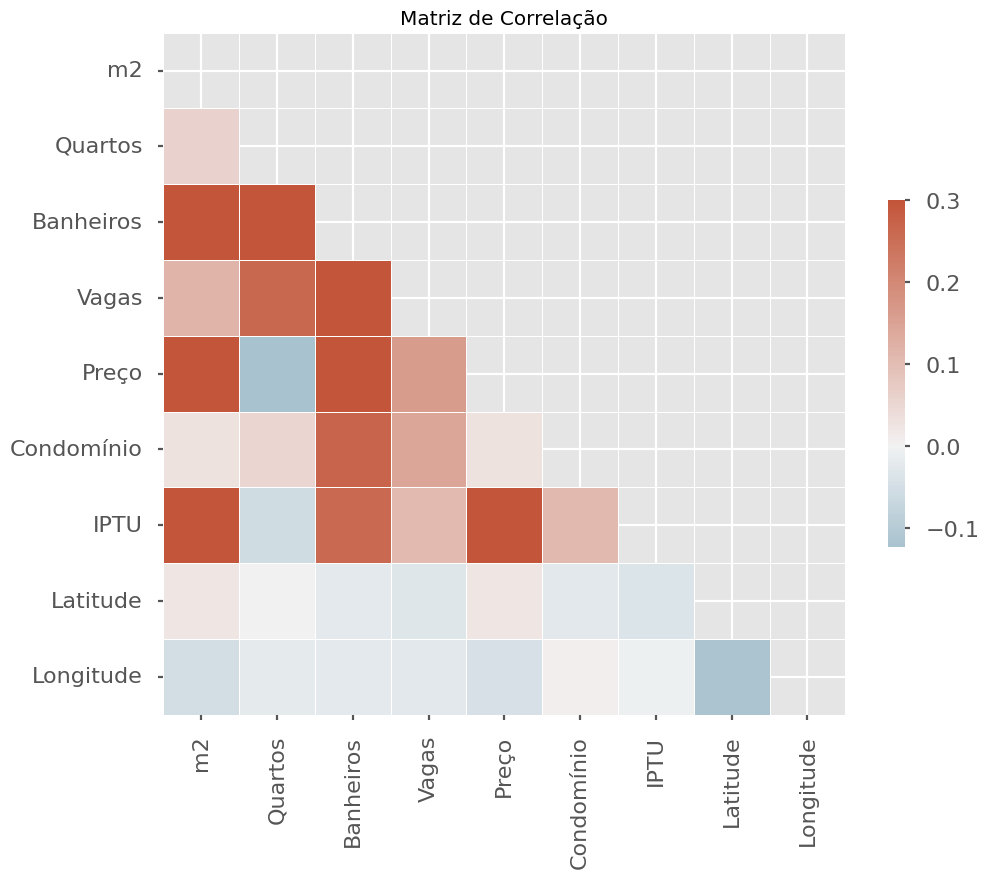

In [ ]:
df_corr = df2[['m2', 'Quartos', 'Banheiros', 'Vagas', 'Preço', 'Condomínio', 'IPTU', 'Latitude', 'Longitude']]
corr = df_corr.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

cmap = sn.diverging_palette(230, 20, as_cmap=True)
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Matriz de Correlação')

## Análises das Distribuições:

<Axes: >

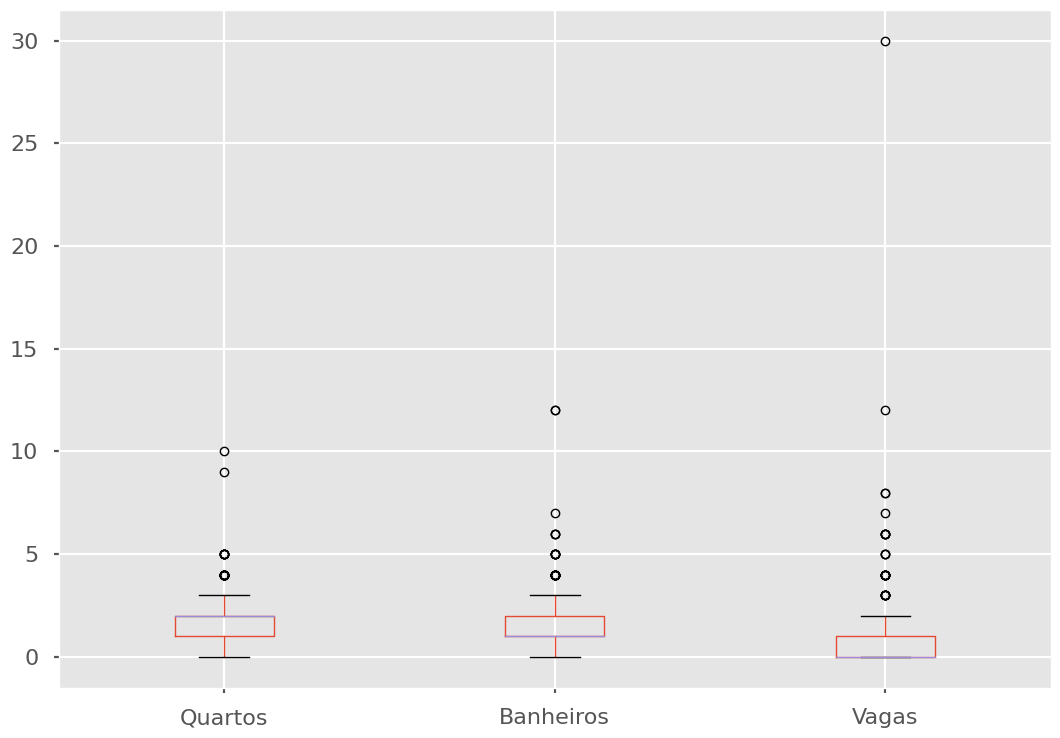

In [ ]:
boxplot = df2.boxplot(column=['Quartos', 'Banheiros', 'Vagas'])
boxplot

<Axes: >

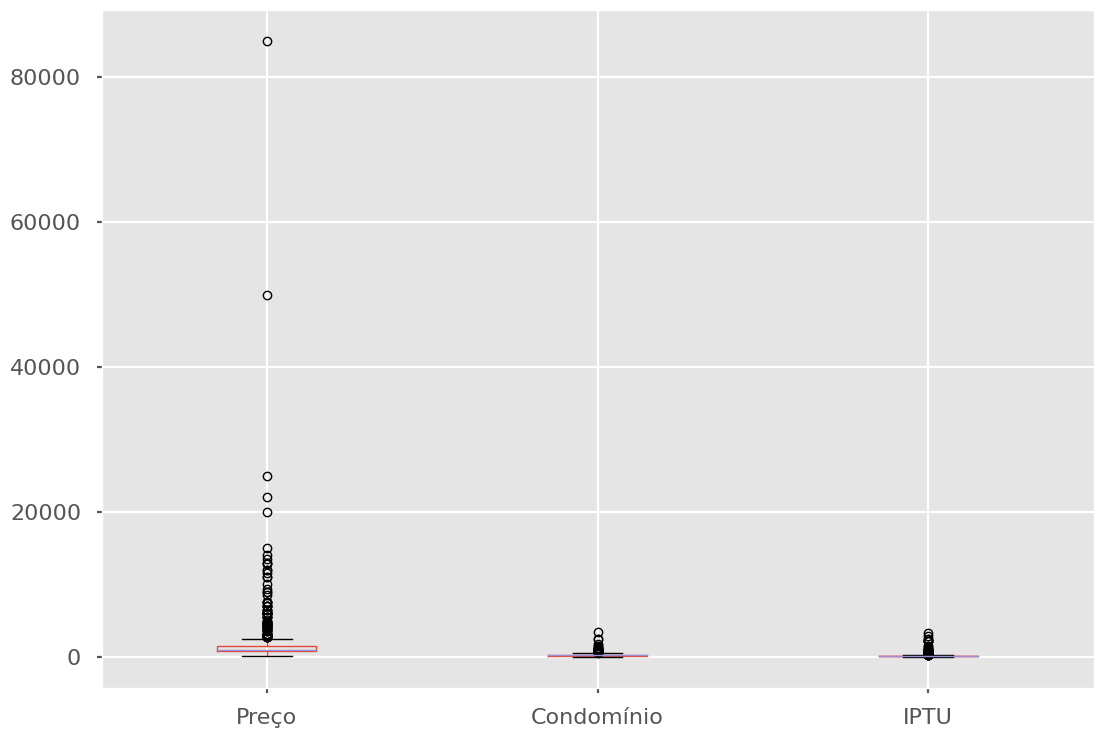

In [ ]:
boxplot = df2.boxplot(column=['Preço', 'Condomínio', 'IPTU'])
boxplot

<Axes: >

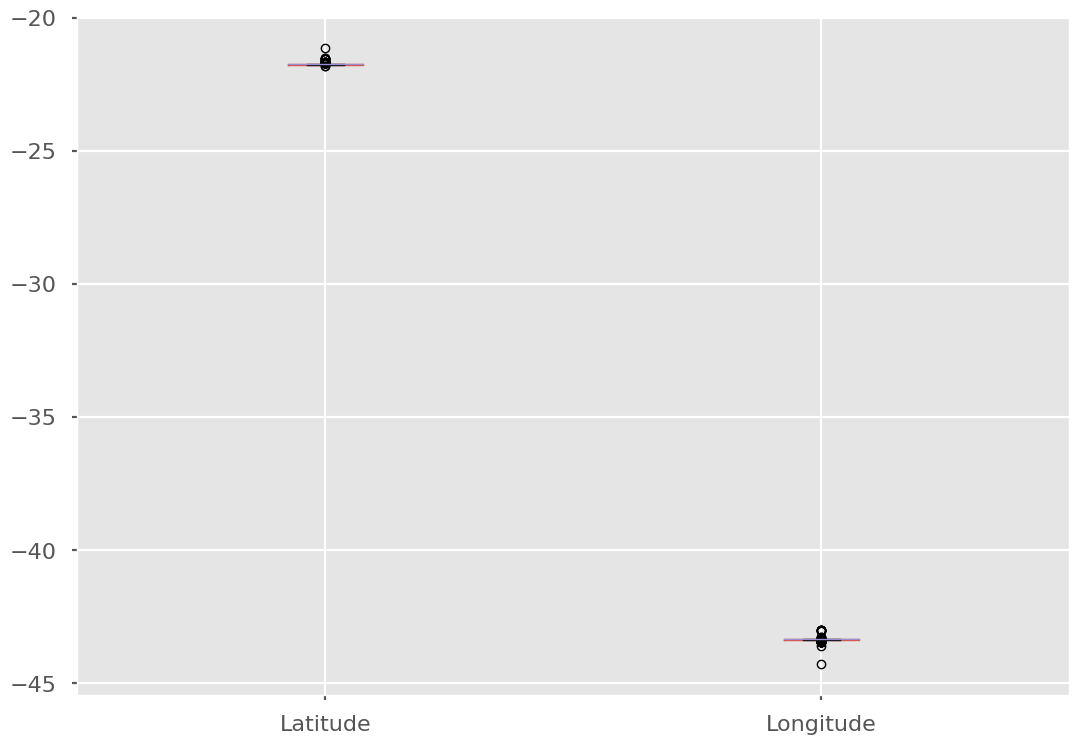

In [ ]:
boxplot = df2.boxplot(column=['Latitude', 'Longitude'])
boxplot

<Axes: >

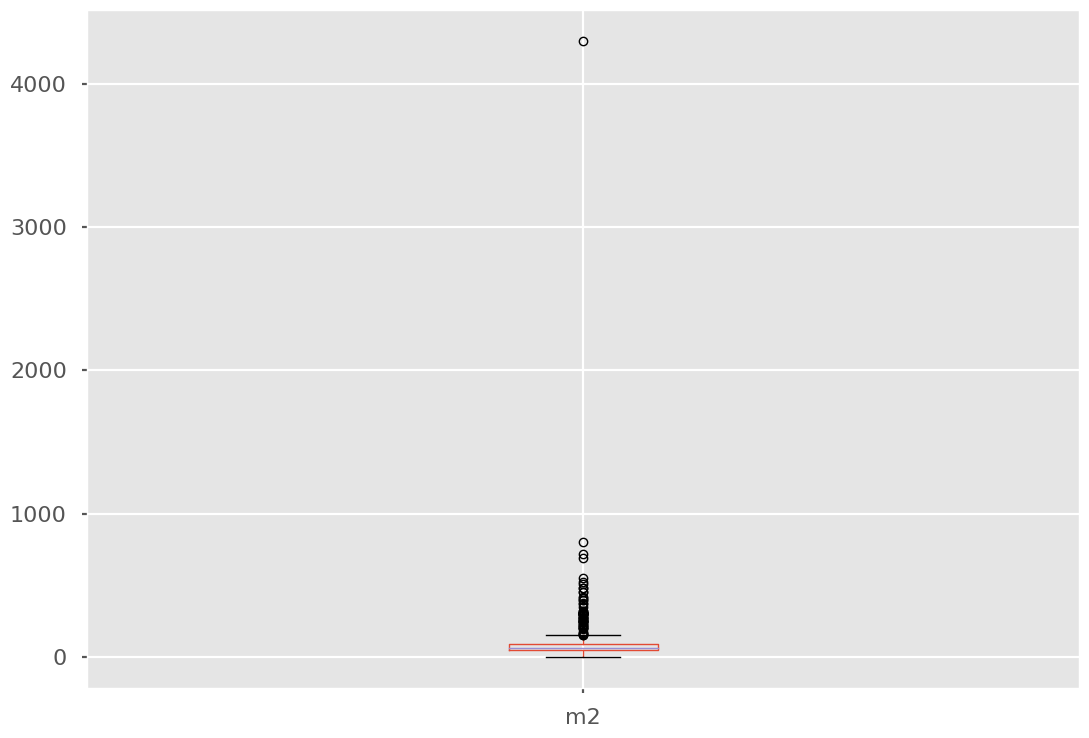

In [ ]:
boxplot = df2.boxplot(column=['m2'])
boxplot

--------------------

# Testes de Modelos de Regressão:

## Formatação da Base de Dados:

In [ ]:
X_1 = df_1.drop(['Preço'], axis=1)
y_1 = df_1[['Preço']]
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=32)

X_2 = df_2.drop(['Preço'], axis=1)
y_2 = df_2[['Preço']]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.05, random_state=32)

X_3 = df_3.drop(['Preço'], axis=1)
y_3 = df_3[['Preço']]
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.1, random_state=32)

X_4 = df_4.drop(['Preço'], axis=1)
y_4 = df_4[['Preço']]
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, test_size=0.05, random_state=32)

X_5 = df_5.drop(['Preço'], axis=1)
y_5 = df_5[['Preço']]
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size=0.2, random_state=32)

datas = []

## Regressão Linear

In [ ]:
model_1 = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)
model_1.fit(X_train_1, y_train_1)
y_predict_1 = model_1.predict(X_test_1)

R2 = r2_score(y_test_1, y_predict_1)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_1, y_predict_1))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_1, y_predict_1)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "Regressão Linear", "Df":"df1", "Tipo":"Apartamento", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.1834650679502341
RMSE = 898.4997423223859
MAPE = 0.38909420726651317


In [ ]:
model_2 = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)
model_2.fit(X_train_2, y_train_2)
y_predict_2 = model_2.predict(X_test_2)

R2 = r2_score(y_test_2, y_predict_2)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_2, y_predict_2))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_2, y_predict_2)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "Regressão Linear", "Df":"df2", "Tipo":"Galpão", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = -9.715334216985568
RMSE = 6641.914706718958
MAPE = 2.095220994436282


In [ ]:
model_3 = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)
model_3.fit(X_train_3, y_train_3)
y_predict_3 = model_3.predict(X_test_3)

R2 = r2_score(y_test_3, y_predict_3)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_3, y_predict_3))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_3, y_predict_3)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "Regressão Linear", "Df":"df3", "Tipo":"Casa", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.8428990221183825
RMSE = 854.3085104711988
MAPE = 0.5020525366014293


In [ ]:
model_4 = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)
model_4.fit(X_train_4, y_train_4)
y_predict_4 = model_4.predict(X_test_4)

R2 = r2_score(y_test_4, y_predict_4)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_4, y_predict_4))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_4, y_predict_4)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "Regressão Linear", "Df":"df4", "Tipo":"Loja", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.10481615497707453
RMSE = 324.7685018799924
MAPE = 0.2952849650494036


In [ ]:
model_5 = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)
model_5.fit(X_train_5, y_train_5)
y_predict_5 = model_5.predict(X_test_5)

R2 = r2_score(y_test_5, y_predict_5)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_5, y_predict_5))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_5, y_predict_5)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "Regressão Linear", "Df":"df5", "Tipo":"Kitnet", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.5546915229972686
RMSE = 530.2645523499261
MAPE = 0.4480160181917266


## KNN

In [ ]:
model_1 = KNeighborsRegressor(n_neighbors=1, weights='distance')
model_1.fit(X_train_1, y_train_1)
y_predict_1 = model_1.predict(X_test_1)

R2 = r2_score(y_test_1, y_predict_1)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_1, y_predict_1))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_1, y_predict_1)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "KNN", "Df":"df1", "Tipo":"Apartamento", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.8584239754483891
RMSE = 374.13249401371576
MAPE = 0.267389945084483


In [ ]:
model_2 = KNeighborsRegressor(n_neighbors=37, weights='distance')
model_2.fit(X_train_2, y_train_2)
y_predict_2 = model_2.predict(X_test_2)

R2 = r2_score(y_test_2, y_predict_2)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_2, y_predict_2))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_2, y_predict_2)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "KNN", "Df":"df2", "Tipo":"Galpão", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.9339639581189574
RMSE = 521.4119143481978
MAPE = 0.3033443015928867


In [ ]:
model_3 = KNeighborsRegressor(n_neighbors=1, weights='distance')
model_3.fit(X_train_3, y_train_3)
y_predict_3 = model_3.predict(X_test_3)

R2 = r2_score(y_test_3, y_predict_3)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_3, y_predict_3))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_3, y_predict_3)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "KNN", "Df":"df3", "Tipo":"Casa", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.9093004139586257
RMSE = 649.1244102635488
MAPE = 0.2567701048951049


In [ ]:
model_4 = KNeighborsRegressor(n_neighbors=2, weights='distance')
model_4.fit(X_train_4, y_train_4)
y_predict_4 = model_4.predict(X_test_4)

R2 = r2_score(y_test_4, y_predict_4)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_4, y_predict_4))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_4, y_predict_4)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "KNN", "Df":"df4", "Tipo":"Loja", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.6676762111031054
RMSE = 197.87844974585556
MAPE = 0.22191318057314874


In [ ]:
model_5 = KNeighborsRegressor(n_neighbors=7, weights='distance')
model_5.fit(X_train_5, y_train_5)
y_predict_5 = model_5.predict(X_test_5)

R2 = r2_score(y_test_5, y_predict_5)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_5, y_predict_5))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_5, y_predict_5)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "KNN", "Df":"df5", "Tipo":"Kitnet", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.8971811255009822
RMSE = 254.79948006385015
MAPE = 0.26029212657680617


## SVN

In [ ]:
scaler_svr = StandardScaler()
X_train_svr_scaled = scaler_svr.fit_transform(X_train_1)
X_test_svr_scaled = scaler_svr.transform(X_test_1)

# Initialize and train SVR model
svr = SVR(kernel="rbf", C=600, gamma=0.0121, epsilon=0.05)
svr.fit(X_train_svr_scaled, y_train_1)

# Make predictions using SVR
y_predict_svr = svr.predict(X_test_svr_scaled)

# Calculate R2, RMSE, and MAPE for SVR
R2_svr = r2_score(y_test_1, y_predict_svr)
print("SVR R2   =", R2_svr)
RMSE_svr = math.sqrt(mean_squared_error(y_test_1, y_predict_svr))
print("SVR RMSE =", RMSE_svr)
MAPE_svr = mean_absolute_percentage_error(y_test_1, y_predict_svr)
print("SVR MAPE =", MAPE_svr)

datas.append({"Algoritmo": "SVN", "Df":"df1", "Tipo":"Apartamento", "R2":R2_svr, "RMSE":RMSE_svr, "MAPE": MAPE_svr})

SVR R2   = 0.7890941033677317
SVR RMSE = 529.4412090146124
SVR MAPE = 0.24828869039425208


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
scaler_svr = StandardScaler()
X_train_svr_scaled = scaler_svr.fit_transform(X_train_2)
X_test_svr_scaled = scaler_svr.transform(X_test_2)

# Initialize and train SVR model
svr = SVR(kernel="rbf", C=800, gamma=0.071, epsilon=0.05)
svr.fit(X_train_svr_scaled, y_train_2)

# Make predictions using SVR
y_predict_svr = svr.predict(X_test_svr_scaled)

# Calculate R2, RMSE, and MAPE for SVR
R2_svr = r2_score(y_test_2, y_predict_svr)
print("SVR R2   =", R2_svr)
RMSE_svr = math.sqrt(mean_squared_error(y_test_2, y_predict_svr))
print("SVR RMSE =", RMSE_svr)
MAPE_svr = mean_absolute_percentage_error(y_test_2, y_predict_svr)
print("SVR MAPE =", MAPE_svr)

datas.append({"Algoritmo": "SVN", "Df":"df2", "Tipo":"Galpão", "R2":R2_svr, "RMSE":RMSE_svr, "MAPE": MAPE_svr})

SVR R2   = 0.9474807888039036
SVR RMSE = 519.7238382861836
SVR MAPE = 0.5391177656553272


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Defina os parâmetros que você quer testar
parametros = {
    'C': list(range(100, 3000, 50)),  # C variando de 100 a 3000 com passo de 50
    'kernel': ['rbf'],
    'gamma': [i * 0.005 for i in range(1, 21)]  # gamma variando de 0.005 a 0.1 com passo de 0.005
}

# Inicialize o StandardScaler
scaler_svr = StandardScaler()
X_train_svr_scaled = scaler_svr.fit_transform(X_train_2)
X_test_svr_scaled = scaler_svr.transform(X_test_2)

# Inicialize o SVR
svr = SVR()

# Inicialize o GridSearchCV
grid_search = GridSearchCV(estimator=svr, param_grid=parametros, scoring='r2', cv=5)

# Ajuste o GridSearchCV aos seus dados
grid_search.fit(X_train_svr_scaled, y_train_2)

# Obtenha os melhores hiperparâmetros e melhor estimador
melhores_parametros = grid_search.best_params_
melhor_modelo = grid_search.best_estimator_

# Faça previsões usando o melhor modelo
X_test_svr_scaled = scaler_svr.transform(X_test_2)
y_predict_svr = melhor_modelo.predict(X_test_svr_scaled)

# Calcule as métricas de avaliação
R2_svr = r2_score(y_test_2, y_predict_svr)
RMSE_svr = math.sqrt(mean_squared_error(y_test_2, y_predict_svr))
MAPE_svr = mean_absolute_percentage_error(y_test_2, y_predict_svr)

# Imprima as métricas de avaliação
print("SVR R2   =", R2_svr)
print("SVR RMSE =", RMSE_svr)
print("SVR MAPE =", MAPE_svr)

# Imprima os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:")
print(melhores_parametros)

# Adicione os resultados ao seu dicionário ou lista 'datas'
datas.append({"Algoritmo": "SVR", "Df": "df3", "Tipo": "Casa", "R2": R2_svr, "RMSE": RMSE_svr, "MAPE": MAPE_svr})

A saída de streaming foi truncada nas últimas 5000 linhas.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expect

SVR R2   = 0.3614702913577563
SVR RMSE = 1812.1915207175646
SVR MAPE = 0.6469062635558277
Melhores hiperparâmetros:
{'C': 2950, 'gamma': 0.03, 'kernel': 'rbf'}


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [ ]:
scaler_svr = StandardScaler()
X_train_svr_scaled = scaler_svr.fit_transform(X_train_3)
X_test_svr_scaled = scaler_svr.transform(X_test_3)

# Initialize and train SVR model
svr = SVR(kernel="rbf", C=2950, gamma=0.03, epsilon=0.03)
svr.fit(X_train_svr_scaled, y_train_3)

# Make predictions using SVR
y_predict_svr = svr.predict(X_test_svr_scaled)

# Calculate R2, RMSE, and MAPE for SVR
R2_svr = r2_score(y_test_3, y_predict_svr)
print("SVR R2   =", R2_svr)
RMSE_svr = math.sqrt(mean_squared_error(y_test_3, y_predict_svr))
print("SVR RMSE =", RMSE_svr)
MAPE_svr = mean_absolute_percentage_error(y_test_3, y_predict_svr)
print("SVR MAPE =", MAPE_svr)

datas.append({"Algoritmo": "SVN", "Df":"df3", "Tipo":"Casa", "R2":R2_svr, "RMSE":RMSE_svr, "MAPE": MAPE_svr})

SVR R2   = 0.8115098386369125
SVR RMSE = 987.4911885853887
SVR MAPE = 0.4473002034040575


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'gamma': [i * 0.001 for i in range(1, 101)]  # gamma variando de 0.001 a 0.1 com passo de 0.001

In [ ]:
# Defina os parâmetros que você quer testar
parametros = {
    'C': list(range(100, 3000, 50)),  # C variando de 100 a 2000 com passo de 50
    'kernel': ['rbf'],
    'gamma': [i * 0.005 for i in range(1, 21)]  # gamma variando de 0.005 a 0.1 com passo de 0.005
}

# Inicialize o StandardScaler
scaler_svr = StandardScaler()
X_train_svr_scaled = scaler_svr.fit_transform(X_train_3)
X_test_svr_scaled = scaler_svr.transform(X_test_3)

# Inicialize o SVR
svr = SVR()

# Inicialize o GridSearchCV
grid_search = GridSearchCV(estimator=svr, param_grid=parametros, scoring='r2', cv=5)

# Ajuste o GridSearchCV aos seus dados
grid_search.fit(X_train_svr_scaled, y_train_3)

# Obtenha os melhores hiperparâmetros e melhor estimador
melhores_parametros = grid_search.best_params_
melhor_modelo = grid_search.best_estimator_

# Faça previsões usando o melhor modelo
X_test_svr_scaled = scaler_svr.transform(X_test_3)
y_predict_svr = melhor_modelo.predict(X_test_svr_scaled)

# Calcule as métricas de avaliação
R2_svr = r2_score(y_test_3, y_predict_svr)
RMSE_svr = math.sqrt(mean_squared_error(y_test_3, y_predict_svr))
MAPE_svr = mean_absolute_percentage_error(y_test_3, y_predict_svr)

# Imprima as métricas de avaliação
print("SVR R2   =", R2_svr)
print("SVR RMSE =", RMSE_svr)
print("SVR MAPE =", MAPE_svr)

# Imprima os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:")
print(melhores_parametros)

# Adicione os resultados ao seu dicionário ou lista 'datas'
datas.append({"Algoritmo": "SVR", "Df": "df3", "Tipo": "Casa", "R2": R2_svr, "RMSE": RMSE_svr, "MAPE": MAPE_svr})

A saída de streaming foi truncada nas últimas 5000 linhas.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expect

SVR R2   = 0.811494291135204
SVR RMSE = 987.531914064765
SVR MAPE = 0.4473111585347137
Melhores hiperparâmetros:
{'C': 2950, 'gamma': 0.03, 'kernel': 'rbf'}


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [ ]:
scaler_svr = StandardScaler()
X_train_svr_scaled = scaler_svr.fit_transform(X_train_4)
X_test_svr_scaled = scaler_svr.transform(X_test_4)

# Initialize and train SVR model
svr = SVR(kernel="rbf", C=600, gamma=0.05, epsilon=0.04)
svr.fit(X_train_svr_scaled, y_train_4)

# Make predictions using SVR
y_predict_svr = svr.predict(X_test_svr_scaled)

# Calculate R2, RMSE, and MAPE for SVR
R2_svr = r2_score(y_test_4, y_predict_svr)
print("SVR R2   =", R2_svr)
RMSE_svr = math.sqrt(mean_squared_error(y_test_4, y_predict_svr))
print("SVR RMSE =", RMSE_svr)
MAPE_svr = mean_absolute_percentage_error(y_test_4, y_predict_svr)
print("SVR MAPE =", MAPE_svr)


datas.append({"Algoritmo": "SVN", "Df":"df4", "Tipo":"Loja", "R2":R2_svr, "RMSE":RMSE_svr, "MAPE": MAPE_svr})

SVR R2   = 0.9583727898950152
SVR RMSE = 86.7116764064269
SVR MAPE = 0.10158110732568251


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
scaler_svr = StandardScaler()
X_train_svr_scaled = scaler_svr.fit_transform(X_train_5)
X_test_svr_scaled = scaler_svr.transform(X_test_5)

# Initialize and train SVR model
svr = SVR(kernel="rbf", C=100, gamma=0.09, epsilon=0.04)
svr.fit(X_train_svr_scaled, y_train_5)

# Make predictions using SVR
y_predict_svr = svr.predict(X_test_svr_scaled)

# Calculate R2, RMSE, and MAPE for SVR
R2_svr = r2_score(y_test_5, y_predict_svr)
print("SVR R2   =", R2_svr)
RMSE_svr = math.sqrt(mean_squared_error(y_test_5, y_predict_svr))
print("SVR RMSE =", RMSE_svr)
MAPE_svr = mean_absolute_percentage_error(y_test_5, y_predict_svr)
print("SVR MAPE =", MAPE_svr)

datas.append({"Algoritmo": "SVN", "Df":"df5", "Tipo":"Kitnet", "R2":R2_svr, "RMSE":RMSE_svr, "MAPE": MAPE_svr})

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR R2   = 0.2770893383562675
SVR RMSE = 675.6230060856316
SVR MAPE = 0.38490556482259225


## Radius Neighbor Regressor:

In [ ]:
model_1 = RadiusNeighborsRegressor( radius=1.0, weights="distance" )
model_1.fit(X_train_1, y_train_1)
y_predict_1 = model_1.predict(X_test_1)

R2 = r2_score(y_test_1, y_predict_1)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_1, y_predict_1))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_1, y_predict_1)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "RNR", "Df":"df1", "Tipo":"Apartamento", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.7724583571034058
RMSE = 474.3086195990239
MAPE = 0.31725103117981823


In [ ]:
model_2 = RadiusNeighborsRegressor( radius=1.0, weights="distance" )
model_2.fit(X_train_2, y_train_2)
y_predict_2 = model_2.predict(X_test_2)

R2 = r2_score(y_test_2, y_predict_2)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_2, y_predict_2))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_2, y_predict_2)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "RNR", "Df":"df2", "Tipo":"Galpão", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.7682198776969169
RMSE = 976.8514541739665
MAPE = 0.8562426016433522


In [ ]:
model_3 = RadiusNeighborsRegressor( radius=1.0, weights="distance" )
model_3.fit(X_train_3, y_train_3)
y_predict_3 = model_3.predict(X_test_3)

R2 = r2_score(y_test_3, y_predict_3)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_3, y_predict_3))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_3, y_predict_3)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "RNR", "Df":"df3", "Tipo":"Casa", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.19251983229322112
RMSE = 1936.8287400708236
MAPE = 0.4703455367954331


In [ ]:
model_4 = RadiusNeighborsRegressor( radius=8.0, weights="distance" )
model_4.fit(X_train_4, y_train_4)
y_predict_4 = model_4.predict(X_test_4)

R2 = r2_score(y_test_4, y_predict_4)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_4, y_predict_4))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_4, y_predict_4)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "RNR", "Df":"df4", "Tipo":"Loja", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.10039700065993584
RMSE = 325.56913922563507
MAPE = 0.2987516661732243


In [ ]:
model_5 = RadiusNeighborsRegressor( radius=1.0, weights="distance" )
model_5.fit(X_train_5, y_train_5)
y_predict_5 = model_5.predict(X_test_5)

R2 = r2_score(y_test_5, y_predict_5)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_5, y_predict_5))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_5, y_predict_5)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "RNR", "Df":"df5", "Tipo":"Kitnet", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.8397221590403788
RMSE = 318.1257741032458
MAPE = 0.3262859009945866


## Polynomial Regression

In [ ]:
poly_1 = PolynomialFeatures(degree=8, include_bias=False)
X_new_1 = poly_1.fit_transform(X_train_1)
new_model_1 = LinearRegression()
new_model_1.fit(X_new_1,y_train_1)
y_predict_1 = model_1.predict(X_test_1)

R2 = r2_score(y_test_1, y_predict_1)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_1, y_predict_1))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_1, y_predict_1)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "Polynomial Regressor", "Df":"df1", "Tipo":"Apartamento", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.7724583571034058
RMSE = 474.3086195990239
MAPE = 0.31725103117981823


In [ ]:
poly_2 = PolynomialFeatures(degree=9, include_bias=False)
X_new_2 = poly_2.fit_transform(X_train_2)
new_model_2 = LinearRegression()
new_model_2.fit(X_new_2,y_train_2)
y_predict_2 = model_2.predict(X_test_2)

R2 = r2_score(y_test_2, y_predict_2)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_2, y_predict_2))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_2, y_predict_2)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "Polynomial Regressor", "Df":"df2", "Tipo":"Galpão", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.7682198776969169
RMSE = 976.8514541739665
MAPE = 0.8562426016433522


In [ ]:
poly_3 = PolynomialFeatures(degree=10, include_bias=False)
X_new_3 = poly_3.fit_transform(X_train_3)
new_model_3 = LinearRegression()
new_model_3.fit(X_new_3,y_train_3)
y_predict_3 = model_3.predict(X_test_3)

R2 = r2_score(y_test_3, y_predict_3)
print("R3   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_3, y_predict_3))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_3, y_predict_3)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "Polynomial Regressor", "Df":"df3", "Tipo":"Casa", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R3   = 0.19251983229322112
RMSE = 1936.8287400708236
MAPE = 0.4703455367954331


In [ ]:
poly_4 = PolynomialFeatures(degree=10, include_bias=False)
X_new_4 = poly_4.fit_transform(X_train_4)
new_model_4 = LinearRegression()
new_model_4.fit(X_new_4,y_train_4)
y_predict_4 = model_4.predict(X_test_4)

R2 = r2_score(y_test_4, y_predict_4)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_4, y_predict_4))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_4, y_predict_4)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "Polynomial Regressor", "Df":"df4", "Tipo":"Loja", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.10039700065993584
RMSE = 325.56913922563507
MAPE = 0.2987516661732243


In [ ]:
poly_5 = PolynomialFeatures(degree=10, include_bias=False)
X_new_5 = poly_5.fit_transform(X_train_5)
new_model_5 = LinearRegression()
new_model_5.fit(X_new_5,y_train_5)
y_predict_5 = model_5.predict(X_test_5)

R2 = r2_score(y_test_5, y_predict_5)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_5, y_predict_5))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_5, y_predict_5)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "Polynomial Regressor", "Df":"df5", "Tipo":"Kitnet", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.8397221590403788
RMSE = 318.1257741032458
MAPE = 0.3262859009945866


## Logistic Regression:

In [ ]:
model_1 = Ridge(alpha=5)
model_1.fit(X_train_1, y_train_1)

y_predict_1 = model_1.predict(X_test_1)

R2 = r2_score(y_test_1, y_predict_1)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_1, y_predict_1))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_1, y_predict_1)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "Logistic Regression", "Df":"df1", "Tipo":"Apartamento", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.7401900346177177
RMSE = 506.82552035776473
MAPE = 0.327341655864097


In [ ]:
model_2 = Ridge(alpha=9)
model_2.fit(X_train_2, y_train_2)
y_predict_2 = model_2.predict(X_test_2)

R2 = r2_score(y_test_2, y_predict_2)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_2, y_predict_2))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_2, y_predict_2)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "Logistic Regression", "Df":"df2", "Tipo":"Galpão", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = -1.0336436427984768
RMSE = 2893.5291388547184
MAPE = 2.426363024488779


In [ ]:
model_3 = Ridge(alpha=15)
model_3.fit(X_train_3, y_train_3)
y_predict_3 = model_3.predict(X_test_3)

R2 = r2_score(y_test_3, y_predict_3)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_3, y_predict_3))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_3, y_predict_3)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "Logistic Regression", "Df":"df3", "Tipo":"Casa", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.2549124197345731
RMSE = 1860.496899981754
MAPE = 0.7073019563536678


In [ ]:
model_4 = Ridge(alpha=2)
model_4.fit(X_train_4, y_train_4)
y_predict_4 = model_4.predict(X_test_4)

R2 = r2_score(y_test_4, y_predict_4)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_4, y_predict_4))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_4, y_predict_4)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "Logistic Regression", "Df":"df4", "Tipo":"Loja", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.07368829122758269
RMSE = 330.3667726604711
MAPE = 0.30921265118301117


In [ ]:
model_5 = Ridge(alpha=10)
model_5.fit(X_train_5, y_train_5)
y_predict_5 = model_5.predict(X_test_5)

R2 = r2_score(y_test_5, y_predict_5)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_5, y_predict_5))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_5, y_predict_5)
print("MAPE =", MAPE)

datas.append({"Algoritmo": "Logistic Regression", "Df":"df5", "Tipo":"Kitnet", "R2":R2, "RMSE":RMSE, "MAPE": MAPE})

R2   = 0.6449664303991303
RMSE = 473.47475081810165
MAPE = 0.5300883195109093


## Métricas

São obrigatórias a avaliação das seguintes métricas:



*   $R^2$: Quanto mais próximo de 1, melhor o resultado
*   RMSE: Quanto menor o valor, melhor o resultado
*   MAPE: Quanto mais próximo de 0, melhor o resultado

**OBS:** Mais métricas para análise podem ser utilizadas.

In [ ]:
d = pd.DataFrame(datas)

In [ ]:
d[d["Df"]=="df1"]

,Algoritmo,Df,Tipo,R2,RMSE,MAPE
0,Regressão Linear,df1,Apartamento,0.183465,898.499742,0.389094
5,KNN,df1,Apartamento,0.858424,374.132494,0.267390
10,SVN,df1,Apartamento,0.186317,896.929098,0.274804
15,RNR,df1,Apartamento,0.772458,474.308620,0.317251
20,Polynomial Regressor,df1,Apartamento,0.772458,474.308620,0.317251
25,Logistic Regression,df1,Apartamento,0.740190,506.825520,0.327342


In [ ]:
d[d["Df"]=="df2"]

,Algoritmo,Df,Tipo,R2,RMSE,MAPE
1,Regressão Linear,df2,Galpão,-9.715334,6641.914707,2.095221
6,KNN,df2,Galpão,0.933964,521.411914,0.303344
11,SVN,df2,Galpão,0.218684,1793.510132,0.717827
16,RNR,df2,Galpão,0.768220,976.851454,0.856243
21,Polynomial Regressor,df2,Galpão,0.768220,976.851454,0.856243
26,Logistic Regression,df2,Galpão,-1.033644,2893.529139,2.426363


In [ ]:
d[d["Df"]=="df3"]

,Algoritmo,Df,Tipo,R2,RMSE,MAPE
2,Regressão Linear,df3,Casa,0.842899,854.308510,0.502053
7,KNN,df3,Casa,0.909300,649.124410,0.256770
12,SVN,df3,Casa,0.031611,2121.046091,0.456522
17,RNR,df3,Casa,0.192520,1936.828740,0.470346
22,Polynomial Regressor,df3,Casa,0.192520,1936.828740,0.470346
27,Logistic Regression,df3,Casa,0.254912,1860.496900,0.707302


In [ ]:
d[d["Df"]=="df4"]

,Algoritmo,Df,Tipo,R2,RMSE,MAPE
3,Regressão Linear,df4,Loja,0.104816,324.768502,0.295285
8,KNN,df4,Loja,0.667676,197.878450,0.221913
13,SVN,df4,Loja,0.183706,310.127999,0.225313
18,RNR,df4,Loja,0.100397,325.569139,0.298752
23,Polynomial Regressor,df4,Loja,0.100397,325.569139,0.298752
28,Logistic Regression,df4,Loja,0.073688,330.366773,0.309213


In [ ]:
d[d["Df"]=="df5"]

,Algoritmo,Df,Tipo,R2,RMSE,MAPE
4,Regressão Linear,df5,Kitnet,0.554692,530.264552,0.448016
9,KNN,df5,Kitnet,0.897181,254.799480,0.260292
14,SVN,df5,Kitnet,0.277089,675.623006,0.384906
19,RNR,df5,Kitnet,0.839722,318.125774,0.326286
24,Polynomial Regressor,df5,Kitnet,0.839722,318.125774,0.326286
29,Logistic Regression,df5,Kitnet,0.644966,473.474751,0.530088


---------------------------------

# Aplicação dos Melhores Modelos:

## Formatação da Base de Dados:

In [ ]:
X_1 = df_1.drop(['Preço'], axis=1)
y_1 = df_1[['Preço']]
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.25, random_state=32)

X_2 = df_2.drop(['Preço'], axis=1)
y_2 = df_2[['Preço']]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.1, random_state=32)

X_3 = df_3.drop(['Preço'], axis=1)
y_3 = df_3[['Preço']]
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.09, random_state=32)

X_4 = df_4.drop(['Preço'], axis=1)
y_4 = df_4[['Preço']]
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, test_size=0.01, random_state=32)

X_5 = df_5.drop(['Preço'], axis=1)
y_5 = df_5[['Preço']]
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size=0.18, random_state=32)

## Implementação dos Modelos:

In [ ]:
model_1_final = KNeighborsRegressor(n_neighbors=2, weights='distance')
model_1_final.fit(X_train_1, y_train_1)
y_predict_1 = model_1_final.predict(X_test_1)

R2 = r2_score(y_test_1, y_predict_1)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_1, y_predict_1))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_1, y_predict_1)
print("MAPE =", MAPE)

R2   = 0.88169208846399
RMSE = 396.5338570945239
MAPE = 0.2626546877754565


In [ ]:
model_2_final = KNeighborsRegressor(n_neighbors=37, weights='distance')
model_2_final.fit(X_train_2, y_train_2)
y_predict_2 = model_2_final.predict(X_test_2)

R2 = r2_score(y_test_2, y_predict_2)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_2, y_predict_2))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_2, y_predict_2)
print("MAPE =", MAPE)

R2   = 0.7545102550155153
RMSE = 1081.9718199064116
MAPE = 0.6123739714374257


In [ ]:
model_3_final = KNeighborsRegressor(n_neighbors=2, weights='distance')
model_3_final.fit(X_train_3, y_train_3)
y_predict_3 = model_3_final.predict(X_test_3)

R2 = r2_score(y_test_3, y_predict_3)
print("R2   =", R2)
RMSE = math.sqrt(mean_squared_error(y_test_3, y_predict_3))
print("RMSE =", RMSE)
MAPE = mean_absolute_percentage_error(y_test_3, y_predict_3)
print("MAPE =", MAPE)

R2   = 0.8554838480966102
RMSE = 864.6634082498341
MAPE = 0.31117587409822106


In [ ]:
scaler_svr = StandardScaler()
X_train_svr_scaled = scaler_svr.fit_transform(X_train_4)
X_test_svr_scaled = scaler_svr.transform(X_test_4)

# Initialize and train SVR model
model_4_final = SVR(kernel="rbf", C=600, gamma=0.05, epsilon=0.04)
model_4_final.fit(X_train_svr_scaled, y_train_4)

# Make predictions using SVR
y_predict_svr = model_4_final.predict(X_test_svr_scaled)

# Calculate R2, RMSE, and MAPE for SVR
R2_svr = r2_score(y_test_4, y_predict_svr)
print("SVR R2   =", R2_svr)
RMSE_svr = math.sqrt(mean_squared_error(y_test_4, y_predict_svr))
print("SVR RMSE =", RMSE_svr)
MAPE_svr = mean_absolute_percentage_error(y_test_4, y_predict_svr)
print("SVR MAPE =", MAPE_svr)

SVR R2   = 0.9583727898950152
SVR RMSE = 86.7116764064269
SVR MAPE = 0.10158110732568251


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
scaler_svr = StandardScaler()
X_train_svr_scaled = scaler_svr.fit_transform(X_train_5)
X_test_svr_scaled = scaler_svr.transform(X_test_5)

# Initialize and train SVR model
model_5_final = SVR(kernel="rbf", C=610, gamma=0.05, epsilon=0.04)
model_5_final.fit(X_train_svr_scaled, y_train_5)

# Make predictions using SVR
y_predict_svr = model_5_final.predict(X_test_svr_scaled)

# Calculate R2, RMSE, and MAPE for SVR
R2_svr = r2_score(y_test_5, y_predict_svr)
print("SVR R2   =", R2_svr)
RMSE_svr = math.sqrt(mean_squared_error(y_test_5, y_predict_svr))
print("SVR RMSE =", RMSE_svr)
MAPE_svr = mean_absolute_percentage_error(y_test_5, y_predict_svr)
print("SVR MAPE =", MAPE_svr)

SVR R2   = 0.8631344238166998
SVR RMSE = 293.9742084727324
SVR MAPE = 0.31080420123297314


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Teste Online

In [ ]:
def tratar_tipo(tipo):
  if tipo == "Cobertura":
    return "Apartamento"
  elif tipo == "Studio":
    return "Kitnet"
  elif tipo == "Sala":
    return "Galpão"
  elif tipo in ["Apartamento", "Kitnet", "Galpão", "Casa", "Loja"]:
    return tipo
  else:
     return "ERRO"

In [ ]:
5# Imputando os dados
ty = input("Tipo do Imóvel: ")
ty = tratar_tipo(ty)
m_2 = int(input("Metros quadrados: "))
n_q = int(input("Número de quartos: "))
n_b = int(input("Número de banheiros: "))
n_vg = int(input("Número de vagas de garagem: "))
cond = float(input("Preço do Condomínio: "))
iptu = float(input("Preço do IPTU: "))
bairro = input("Bairro (texto): ")
# Transformando o bairro em texto para Lat, Lon
geolocator = Nominatim(user_agent="geolocalização")
location = geolocator.geocode(bairro + ', Juiz de Fora - MG')
lat = location.latitude; lon = location.longitude

# Colocando os dados em um Dataframe
col_online = ['m2', 'Quartos', 'Banheiros', 'Vagas', 'Condomínio', 'IPTU',	'Latitude', 'Longitude']
X_online = [m_2, n_q, n_b, n_vg, cond, iptu, lat, lon]
X_online = pd.DataFrame([X_online], columns = col_online)

# Prevendo o valor do preço do imóvel
match ty:
  case "Apartamento":
    y_online = model_1_final.predict(X_online)
    print('Preço previsto: ', y_online)
  case "Kitnet":
    y_online = model_2_final.predict(X_online)
    print('Preço previsto: ', y_online)
  case "Galpão":
    y_online = model_3_final.predict(X_online)
    print('Preço previsto: ', y_online)
  case "Casa":
    y_online = model_4_final.predict(X_online)
    print('Preço previsto: ', y_online)
  case "Loja":
    y_online = model_5_final.predict(X_online)
    print('Preço previsto: ', y_online)
  case _:
    print("ERROR")
# Resultado

# print(f"Preço do imóvel previsto:{y_online}")

Tipo do Imóvel: Apartamento
Metros quadrados: 100
Número de quartos: 10
Número de banheiros: 10
Número de vagas de garagem: 10
Preço do Condomínio: 1000
Preço do IPTU: 10000
Bairro (texto): Centro
Preço previsto:  [[9249.99617683]]
